In [2]:
from google.cloud import storage
from collections import defaultdict
import os
import re
import random
import os

PROJECT = !gcloud config list --format 'value(core.project)'
PROJECT = PROJECT[0]
BUCKET = PROJECT+"-capstone"
REGION = "us-central1"

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

# Initialize the storage client
storage_client = storage.Client()

# Set bucket name from environment variable
bucket_name = os.environ["BUCKET"]
bucket = storage_client.bucket(bucket_name)

image_folder = "test"

# List all image files in the specified folder
blobs = bucket.list_blobs(prefix=image_folder)

image_urls = []
labels = []
images = []


# Dictionary to keep track of image counts per label
label_counts = defaultdict(int)

# Dictionary to set a random limit for each label
label_limits = defaultdict(lambda: random.randint(600, 700))

# Collect image URLs and their labels, limit to a random number between 600 and 700 per label
for blob in blobs:
    if blob.name.lower().endswith(('.png', '.jpg', '.jpeg')) and blob.name.lower().startswith('test/tomato'):
        label = blob.name.replace('test/', '')
        if label_counts[label] < label_limits[label]:
            image_urls.append(f"gs://{bucket_name}/{blob.name}")
            labels.append(label)
            label_counts[label] += 1

print(f"Found {len(image_urls)} images.")

# Print the count of images for each label
for label, count in label_counts.items():
    print(f"Label: {label}, Number of Images: {count}")


Found 16 images.
Label: TomatoEarlyBlight1.JPG, Number of Images: 1
Label: TomatoEarlyBlight2.JPG, Number of Images: 1
Label: TomatoEarlyBlight3.JPG, Number of Images: 1
Label: TomatoEarlyBlight4.JPG, Number of Images: 1
Label: TomatoEarlyBlight5.JPG, Number of Images: 1
Label: TomatoEarlyBlight6.JPG, Number of Images: 1
Label: TomatoHealthy1.JPG, Number of Images: 1
Label: TomatoHealthy2.JPG, Number of Images: 1
Label: TomatoHealthy3.JPG, Number of Images: 1
Label: TomatoHealthy4.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus1.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus2.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus3.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus4.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus5.JPG, Number of Images: 1
Label: TomatoYellowCurlVirus6.JPG, Number of Images: 1


In [3]:
CLASSES = ["Tomato___Bacterial_spot", 
"Tomato___Early_blight", 
"Tomato___Late_blight",
"Tomato___Leaf_Mold",
"Tomato___Septoria_leaf_spot",
"Tomato___Spider_mites Two-spotted_spider_mite",
"Tomato___Target_Spot",
"Tomato___Tomato_Yellow_Leaf_Curl_Virus",
"Tomato___Tomato_mosaic_virus",
"Tomato___healthy"]

In [21]:
import numpy as np
import tensorflow as tf

# Helper function to download and preprocess an image
def download_and_preprocess_image(url):
    img = tf.io.read_file(url)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Download and preprocess test images
test_images = np.vstack([download_and_preprocess_image(url) for url in image_urls])

# fine-tuning 5 layers 
model = tf.keras.models.load_model('../model/model_mb_v2_finetuned.hdf5')

# Make predictions
predictions = model.predict(test_images)

# Print predictions
for url, prediction in zip(image_urls, predictions):
    pred_label_index = tf.math.argmax(prediction).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = prediction[pred_label_index]
    print(f"Image URL: {url}, Prediction: {pred_label} ({prob:.2f})")


1/1 [==============================] - 1s 1s/step
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG, Prediction: Tomato___Early_blight (0.96)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight2.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight3.JPG, Prediction: Tomato___Early_blight (0.82)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight4.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight5.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight6.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy1.JPG, Prediction: Tomato___healthy (0.98)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy2.JPG, Prediction: 

In [20]:
model = tf.keras.models.load_model('../model/model_mb_v2_pretrained.hdf5')

# Make predictions
predictions = model.predict(test_images)

# Print predictions
for url, prediction in zip(image_urls, predictions):
    pred_label_index = tf.math.argmax(prediction).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = prediction[pred_label_index]
    print(f"Image URL: {url}, Prediction: {pred_label} ({prob:.2f})")

1/1 [==============================] - 1s 1s/step
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight2.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight3.JPG, Prediction: Tomato___Early_blight (0.89)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight4.JPG, Prediction: Tomato___Early_blight (0.96)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight5.JPG, Prediction: Tomato___Early_blight (0.48)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight6.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy1.JPG, Prediction: Tomato___healthy (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy2.JPG, Prediction: 

In [25]:
model = tf.keras.models.load_model('../model/model_mb_v2_finetuned_10.hdf5')

# Make predictions
predictions = model.predict(test_images)

# Print predictions
for url, prediction in zip(image_urls, predictions):
    pred_label_index = tf.math.argmax(prediction).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = prediction[pred_label_index]
    print(f"Image URL: {url}, Prediction: {pred_label} ({prob:.2f})")

1/1 [==============================] - 1s 648ms/step
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight2.JPG, Prediction: Tomato___Bacterial_spot (0.96)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight3.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight4.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight5.JPG, Prediction: Tomato___Early_blight (0.98)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight6.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy1.JPG, Prediction: Tomato___healthy (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy2.JPG, Predict

In [27]:
model = tf.keras.models.load_model('../model/model_mb_v2_finetuned_5_reducelr.hdf5')

# Make predictions
predictions = model.predict(test_images)

# Print predictions
for url, prediction in zip(image_urls, predictions):
    pred_label_index = tf.math.argmax(prediction).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = prediction[pred_label_index]
    print(f"Image URL: {url}, Prediction: {pred_label} ({prob:.2f})")

1/1 [==============================] - 1s 1s/step
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight2.JPG, Prediction: Tomato___Bacterial_spot (0.96)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight3.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight4.JPG, Prediction: Tomato___Early_blight (0.99)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight5.JPG, Prediction: Tomato___Early_blight (0.98)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight6.JPG, Prediction: Tomato___Early_blight (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy1.JPG, Prediction: Tomato___healthy (1.00)
Image URL: gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy2.JPG, Prediction

1/1 [==============================] - 0s 55ms/step


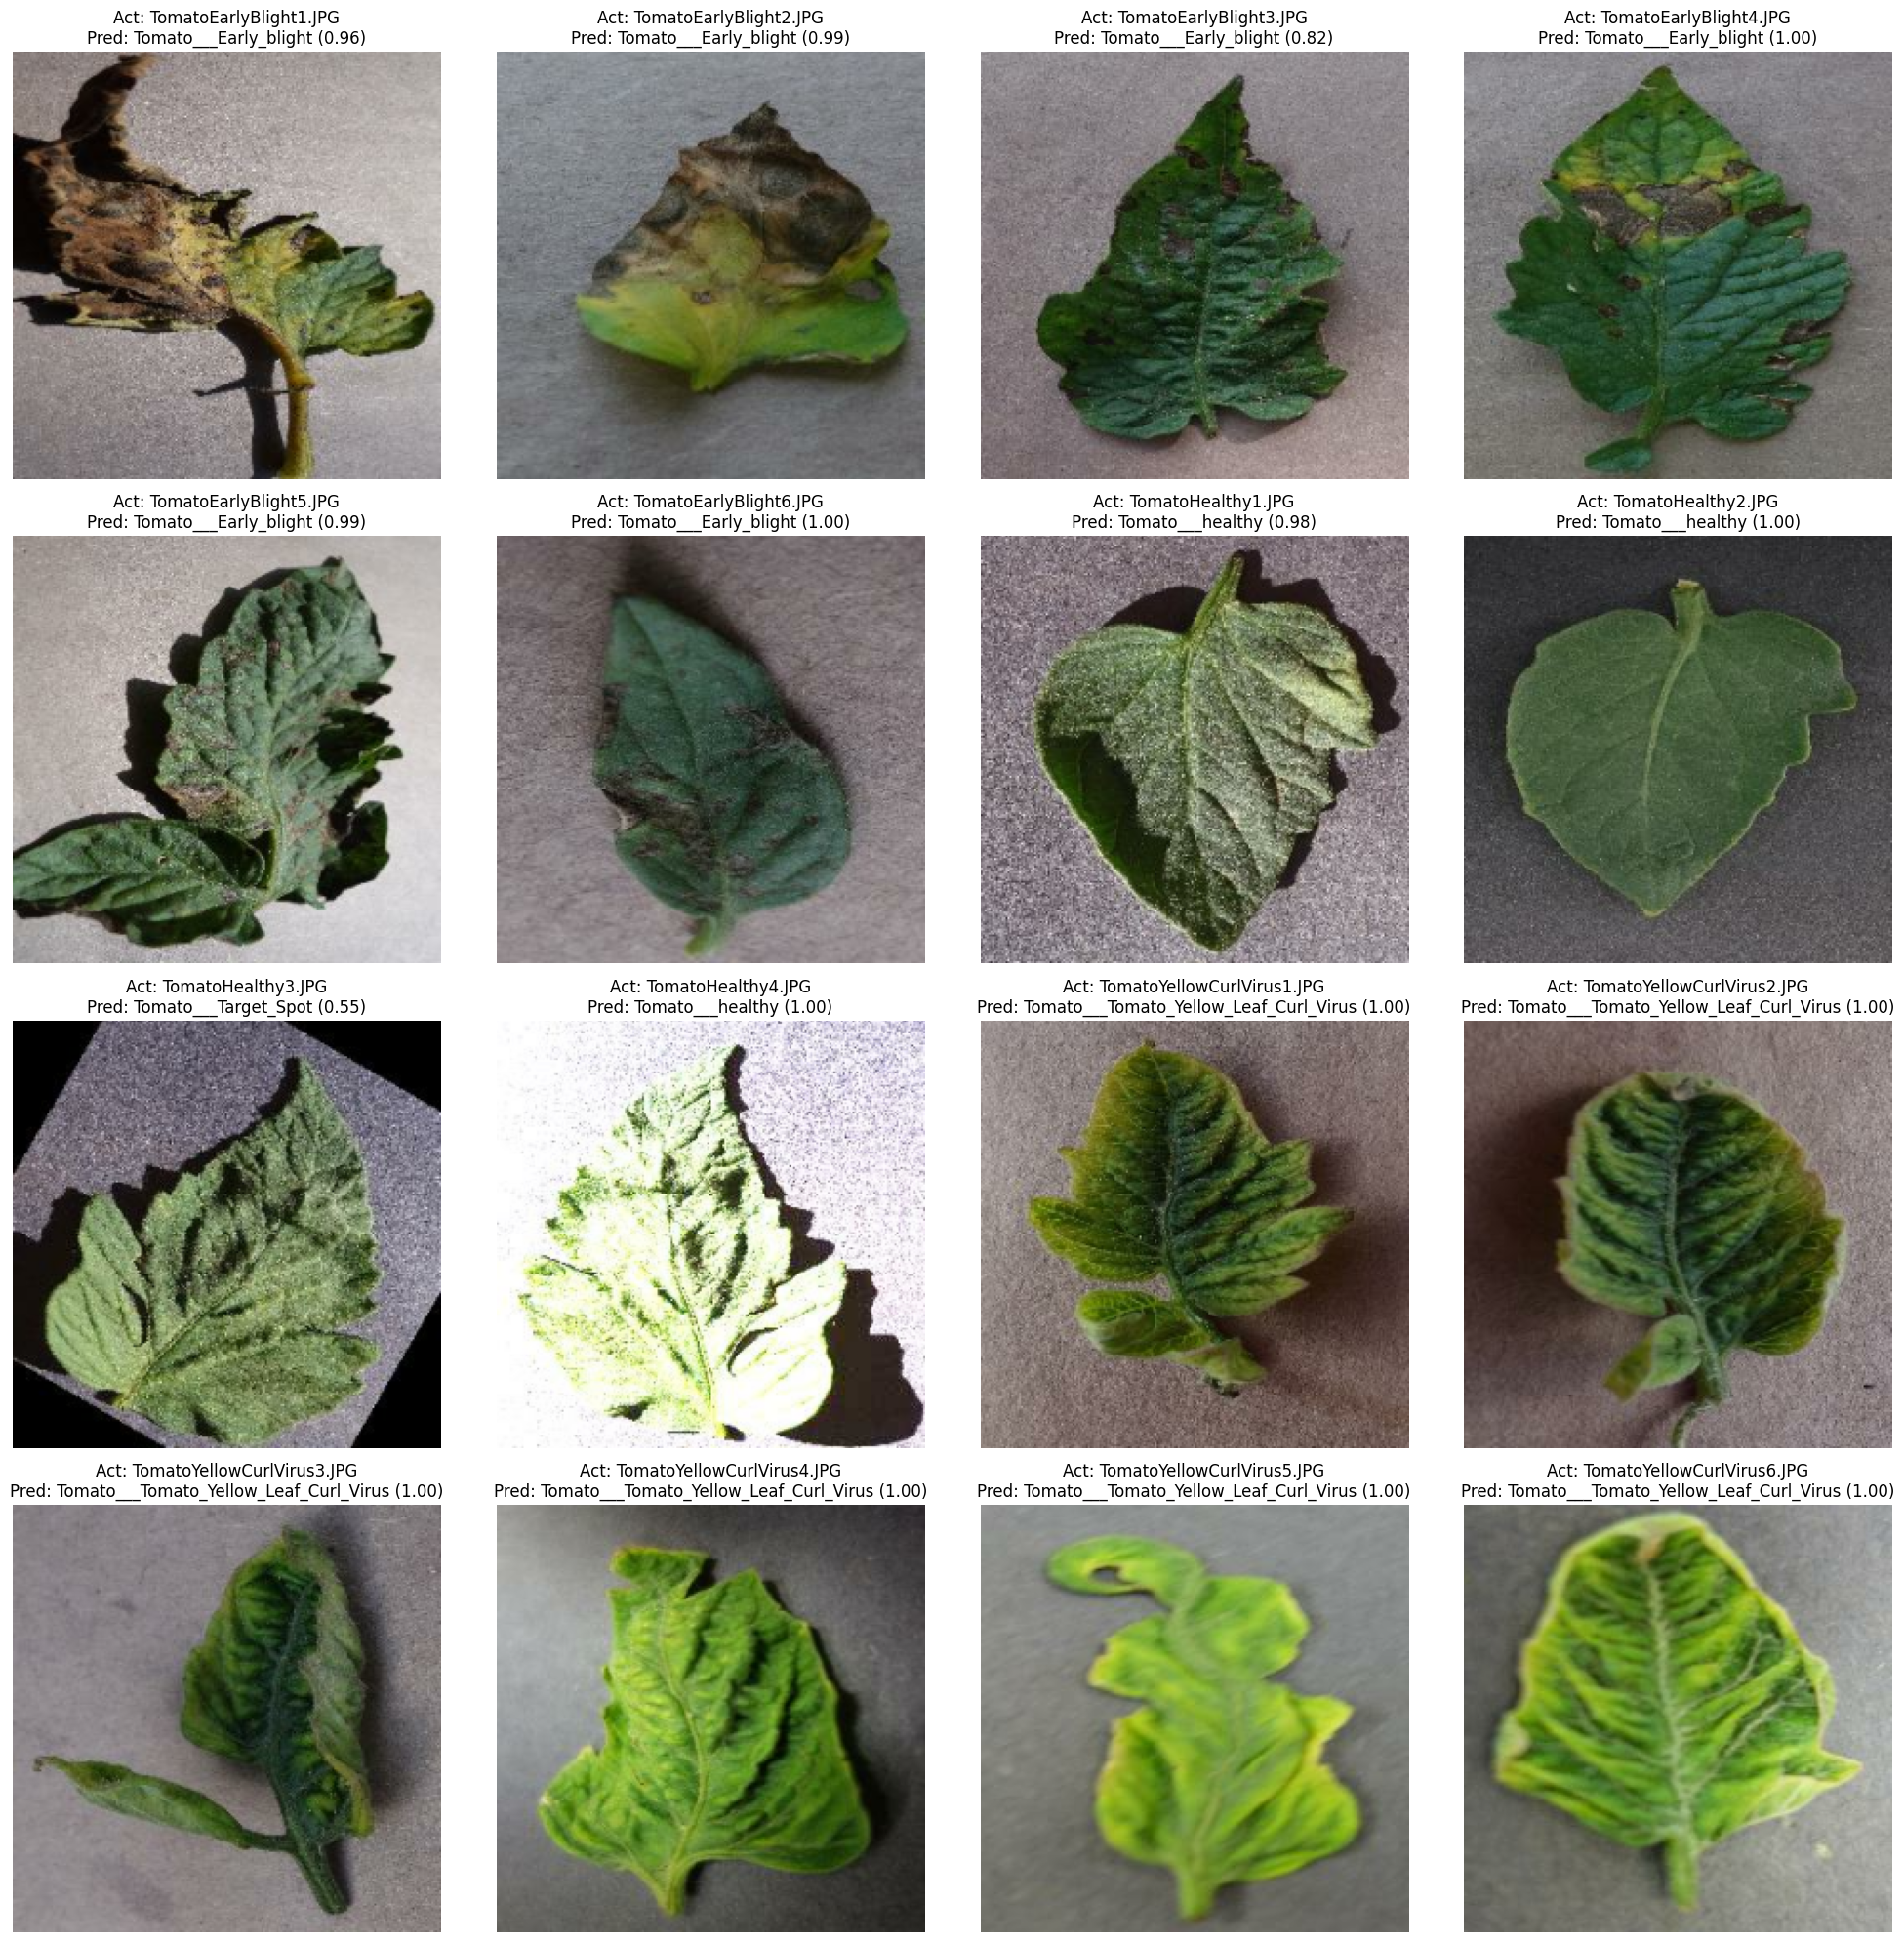

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


filenames = image_urls


def preprocess(img_bytes):
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    return img


def read_from_jpegfile(filename):
    img = tf.io.read_file(filename)
    img = preprocess(img)
    return img


serving_model = tf.keras.models.load_model('../model/model_mb_v2_finetuned.hdf5')
input_images = [read_from_jpegfile(f) for f in filenames]

rows, cols = 4, 4
f, ax = plt.subplots(rows, cols, figsize=(20, 20))

for idx, (img, filename) in enumerate(zip(input_images, filenames)):
    row, col = divmod(idx, cols)
    ax[row, col].imshow(img.numpy())
    batch_image = tf.expand_dims(img, axis=0)
    batch_pred = serving_model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = pred[pred_label_index]
    
    # Extract the actual filename from the full path
    actual_filename = filename.split('/')[-1]
    
    ax[row, col].set_title(f"Act: {actual_filename}\nPred: {pred_label} ({prob:.2f})")
    ax[row, col].axis('off')

# Hide any remaining empty subplots
for idx in range(len(input_images), rows * cols):
    row, col = divmod(idx, cols)
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

In [32]:
model = tf.keras.models.load_model('../model/model_mb_v2_pretrained.hdf5')
model.save("../model/export/mobilenet_v2_transfer_learning")

INFO:tensorflow:Assets written to: ../model/export/mobilenet_v2_transfer_learning/assets


INFO:tensorflow:Assets written to: ../model/export/mobilenet_v2_transfer_learning/assets


In [33]:
import base64
import json
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

REGION = "us-central1"
MODEL_DISPLAYNAME = f"mobilenet_v2_finetuning_5layer_readucelr-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-11:latest"
)

MODEL_DISPLAYNAME: mobilenet_v2_finetuning_5layer_readucelr-20240626092107


In [34]:
!gsutil cp -R ../model/export/mobilenet_v2_finetuning_5layer_readucelr gs://{BUCKET}/{MODEL_DISPLAYNAME}

Copying file://../model/export/mobilenet_v2_finetuning_5layer_readucelr/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://../model/export/mobilenet_v2_finetuning_5layer_readucelr/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://../model/export/mobilenet_v2_finetuning_5layer_readucelr/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://../model/export/mobilenet_v2_finetuning_5layer_readucelr/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][  3.1 MiB/  3.1 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://../model/export/mobilenet_v2_finetuning_5layer_readucelr/variables/variables.data-00000-of-00001 [Content-Type=applica

In [7]:
instances = [{"filenames": f} for f in image_urls]

In [8]:
instances

[{'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight2.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight3.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight4.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight5.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight6.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy1.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy2.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy3.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoHealthy4.JPG'},
 {'filenames': 'gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoYellowCurlVirus1.JPG'},
 {'filenames': 'gs://q

In [16]:
from typing import Dict, List, Union

from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def predict_custom_trained_model_sample(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    """
    `instances` can be either single instance of type dict or a list
    of instances.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances = instances if isinstance(instances, list) else [instances]
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # The predictions are a google.protobuf.Value representation of the model's predictions.
    predictions = response.predictions
    for prediction in predictions:
        print(" prediction:", dict(prediction))


In [ ]:
pred = predict_custom_trained_model_sample(
    project="853791352780",
    endpoint_id="8514703807404310528",
    location="us-central1",
    instances= "gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG"
)

In [22]:
# Download a sample image from GCS.
!gsutil cp gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG sample.jpg

import base64

def b64encode(filename):
    with open(filename, "rb") as ifp:
        img_bytes = ifp.read()
        return base64.b64encode(img_bytes).decode()


data = {
    "instances": [{"img_bytes": {"b64": b64encode("./sample.jpg")}}]
}

Copying gs://qwiklabs-asl-03-66fd43168cb6-capstone/test/TomatoEarlyBlight1.JPG...
/ [1 files][ 18.0 KiB/ 18.0 KiB]                                                
Operation completed over 1 objects/18.0 KiB.                                     


In [24]:
from oauth2client.client import GoogleCredentials

token = (
    GoogleCredentials.get_application_default().get_access_token().access_token
)
headers = {"Authorization": "Bearer " + token}

In [28]:
ENDPOINT_ID="8514703807404310528"
PROJECT_ID="853791352780"
INPUT_DATA_FILE="INPUT-JSON"
REGION = "us-central1"

In [32]:
import requests
import json
api = "https://{}-aiplatform.googleapis.com/v1/projects/{}/locations/{}/endpoints/{}:rawPredict".format(
    REGION, PROJECT, REGION, ENDPOINT_ID
)

response = requests.post(api, json=data, headers=headers)
json.loads(response.content)

{'error': "Failed to process element: 0 key: img_bytes of 'instances' list. Error: INVALID_ARGUMENT: JSON object: does not have named input: img_bytes"}